#  <center> </center>
# <center>Trabajo Practico 1 </center>
### <center>Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré
#### Alan Mejia

# 0. Inicializacion de los datos

## Importando Librerias


In [243]:
#Manipulacion de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pydotplus
import math

from six import StringIO
from IPython.display import Image
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

Instalamos dtreeviz para la parte de entrenamiento y prediccion.

In [157]:
!pip install 'dtreeviz'

ERROR: Invalid requirement: "'dtreeviz'"


In [158]:
import dtreeviz

# 3. Clasificacion

## Importado del dataset

In [159]:
conjunto_entrenamiento_final = pd.read_csv("Datasets/conjunto_entrenamiento_final.csv")
conjunto_entrenamiento_final

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter
0,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0,1429.310345
1,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0,1414.285714
2,-34.610027,-58.401934,Balvanera,Departamento,2.0,4.0,104.0,138.0,146000.0,1057.971014
3,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0,2118.644068
4,-34.623886,-58.412746,Boedo,PH,1.0,2.0,46.0,61.0,100000.0,1639.344262
...,...,...,...,...,...,...,...,...,...,...
65445,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0,2736.500000
65446,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0,2469.135802
65447,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0,2096.774194
65448,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0,2785.361111


## a. Construccion del target

Vamos a mostrar la distribucion del precio por metro cuadrado.

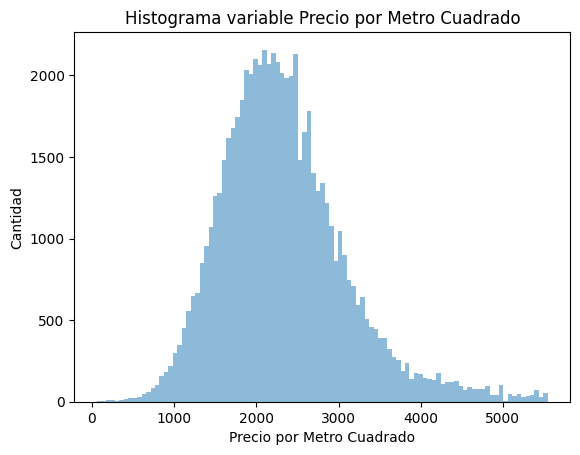

In [160]:
hist_pxm2=conjunto_entrenamiento_final['price_per_square_meter'].plot.hist(alpha=0.5,bins=101,
                                                                           title="Histograma variable Precio por Metro Cuadrado",
                                                                           xlabel="Precio por Metro Cuadrado",
                                                                           ylabel="Cantidad")

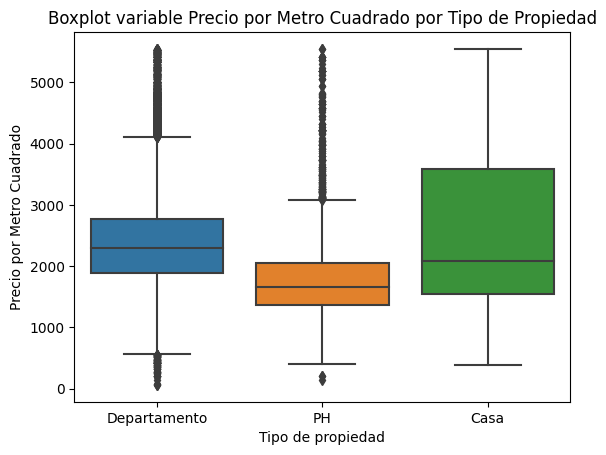

In [161]:
box_plot_pxm2_por_tipo=sns.boxplot(x="property_type",
                                   y="price_per_square_meter",
                                   data=conjunto_entrenamiento_final).set(title="Boxplot variable Precio por Metro Cuadrado por Tipo de Propiedad",
                                   xlabel="Tipo de propiedad",
                                   ylabel="Precio por Metro Cuadrado")

In [162]:
conjunto_entrenamiento_final['price_per_square_meter'].describe()

count    65450.000000
mean      2332.326853
std        768.293705
min         60.240964
25%       1811.602629
50%       2244.715360
75%       2732.048132
max       5546.875000
Name: price_per_square_meter, dtype: float64

In [163]:
conjunto_entrenamiento_final.groupby('property_type')['price_per_square_meter'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Casa,1170.0,2578.364711,1340.922365,391.304348,1543.209877,2085.410334,3590.361446,5542.168675
Departamento,58240.0,2386.269074,739.932360,60.240964,1888.888889,2302.325581,2777.777778,5546.875000
PH,6040.0,1764.535591,637.932946,133.867470,1360.220588,1666.666667,2047.619048,5542.168675


Vamos a probar las tres altenativas siguientes :

### 1. Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

Tenemos 67877 observaciones, asi vamos a divider el conjunto en 3 conjuntos de 22626 observaciones.

In [164]:
def assign_tipo_precio(df):
    df['tipo_precio'] = None
    limite_grupo_1 = int(np.round(df.shape[0] / 4))
    limite_grupo_2 = int(np.round(3 * df.shape[0] / 4))
    df.loc[:limite_grupo_1, 'tipo_precio'] = 'Bajo'
    df.loc[limite_grupo_1:limite_grupo_2, 'tipo_precio'] = 'Medio'
    df.loc[limite_grupo_2:, 'tipo_precio'] = 'Alto'
    return df

In [165]:
pxm2_ascending = conjunto_entrenamiento_final.sort_values(by=['price_per_square_meter'], ascending=True).reset_index(drop=True)
limite_grupo_1 = int(np.round(pxm2_ascending.shape[0] / 3))
limite_grupo_2 = int(np.round(2 * pxm2_ascending.shape[0] / 3))
pxm2_ascending.loc[:limite_grupo_1, 'tipo_precio'] = 'Bajo'
pxm2_ascending.loc[limite_grupo_1:limite_grupo_2, 'tipo_precio'] = 'Medio'
pxm2_ascending.loc[limite_grupo_2:, 'tipo_precio'] = 'Alto'
pxm2_ascending

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter,tipo_precio
0,-34.587265,-58.389767,Recoleta,Departamento,2.0,3.0,67.0,83.0,5000.0,60.240964,Bajo
1,-34.579756,-58.406144,Palermo,Departamento,2.0,3.0,110.0,120.0,7500.0,62.500000,Bajo
2,-34.576973,-58.406591,Palermo Chico,Departamento,2.0,3.0,67.0,83.0,6200.0,74.698795,Bajo
3,-34.569770,-58.431032,Palermo,Departamento,3.0,4.0,136.0,145.0,11111.0,76.627586,Bajo
4,-34.612215,-58.360230,Puerto Madero,Departamento,2.0,3.0,67.0,83.0,11000.0,132.530120,Bajo
...,...,...,...,...,...,...,...,...,...,...,...
65445,-34.614185,-58.462744,Villa Gral. Mitre,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65446,-34.552525,-58.487006,Saavedra,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65447,-34.617091,-58.373067,San Telmo,PH,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65448,-34.605177,-58.444223,Villa Crespo,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto


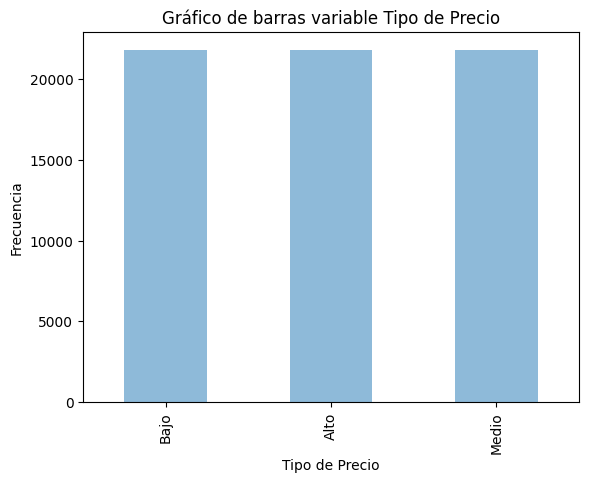

In [166]:
barras_pxm2_ascending=pxm2_ascending['tipo_precio'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Tipo de Precio",
                                                      xlabel="Tipo de Precio" ,
                                                      ylabel="Frecuencia")

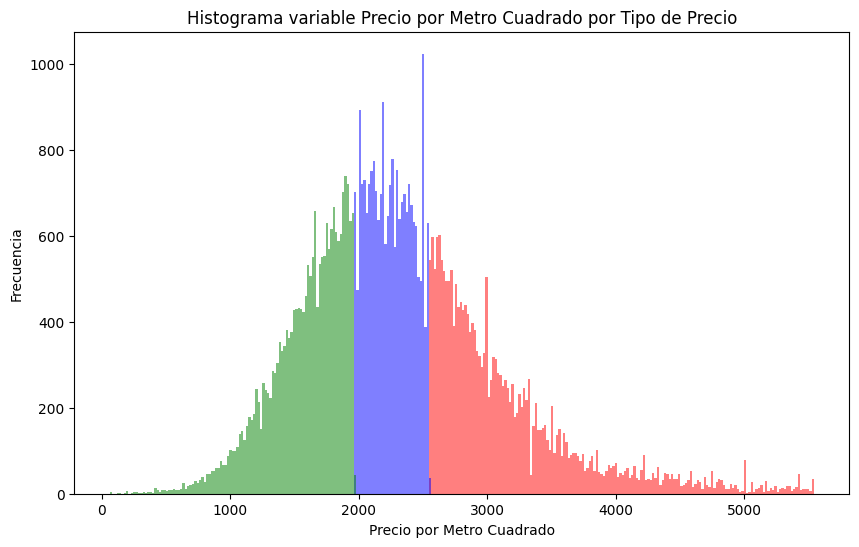

In [167]:
bin_edges = np.linspace(pxm2_ascending['price_per_square_meter'].min(), pxm2_ascending['price_per_square_meter'].max(), 301)
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending[pxm2_ascending['tipo_precio'] == tipo_precio]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=bin_edges, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

### 2. Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones, el siguiente con el 50% y el último con el 25% de las observaciones restantes.

In [168]:
pxm2_ascending_2 = pxm2_ascending.copy()
pxm2_ascending_2 = assign_tipo_precio(pxm2_ascending_2)
pxm2_ascending_2

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter,tipo_precio
0,-34.587265,-58.389767,Recoleta,Departamento,2.0,3.0,67.0,83.0,5000.0,60.240964,Bajo
1,-34.579756,-58.406144,Palermo,Departamento,2.0,3.0,110.0,120.0,7500.0,62.500000,Bajo
2,-34.576973,-58.406591,Palermo Chico,Departamento,2.0,3.0,67.0,83.0,6200.0,74.698795,Bajo
3,-34.569770,-58.431032,Palermo,Departamento,3.0,4.0,136.0,145.0,11111.0,76.627586,Bajo
4,-34.612215,-58.360230,Puerto Madero,Departamento,2.0,3.0,67.0,83.0,11000.0,132.530120,Bajo
...,...,...,...,...,...,...,...,...,...,...,...
65445,-34.614185,-58.462744,Villa Gral. Mitre,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65446,-34.552525,-58.487006,Saavedra,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65447,-34.617091,-58.373067,San Telmo,PH,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65448,-34.605177,-58.444223,Villa Crespo,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto


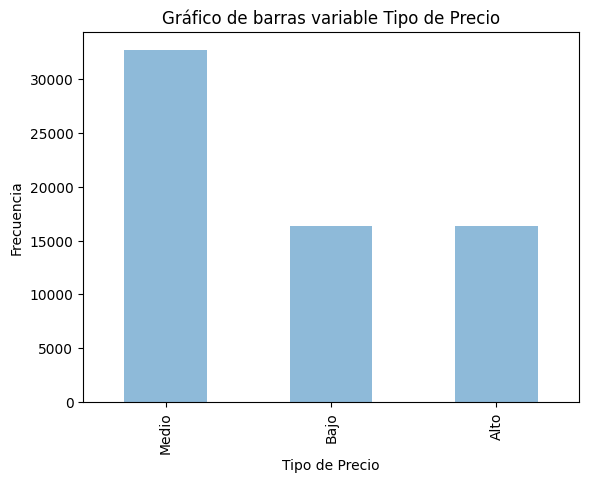

In [169]:
barras_pxm2_ascending_2=pxm2_ascending_2['tipo_precio'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Tipo de Precio",
                                                      xlabel="Tipo de Precio" ,
                                                      ylabel="Frecuencia")

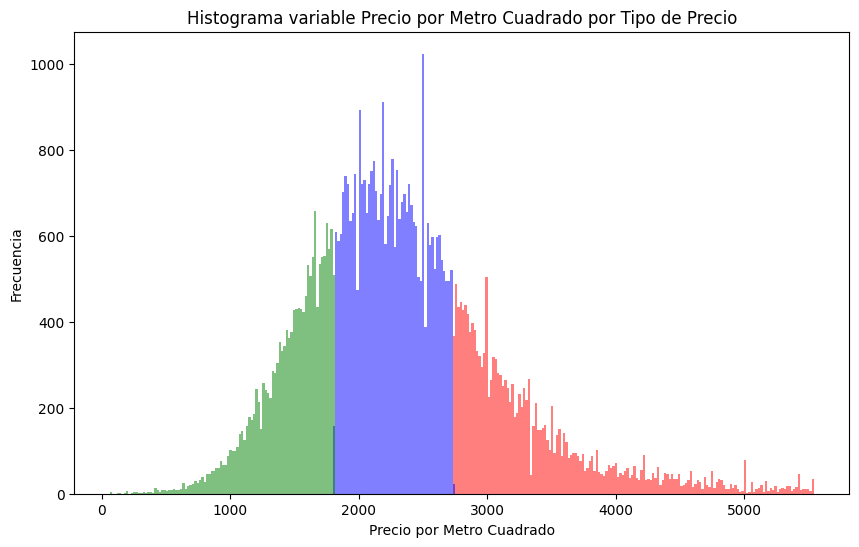

In [170]:
bin_edges = np.linspace(pxm2_ascending['price_per_square_meter'].min(), pxm2_ascending['price_per_square_meter'].max(), 301)
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending_2[pxm2_ascending_2['tipo_precio'] == tipo_precio]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=bin_edges, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

### 3. Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en el punto anterior.

In [171]:
pxm2_ascending_3 = pxm2_ascending.copy()
pxm2_ascending_3_casa = pxm2_ascending_3[pxm2_ascending_3['property_type'] == "Casa"].reset_index(drop=True)
pxm2_ascending_3_casa = assign_tipo_precio(pxm2_ascending_3_casa)
pxm2_ascending_3_ph = pxm2_ascending_3[pxm2_ascending_3['property_type'] == "PH"].reset_index(drop=True)
pxm2_ascending_3_ph = assign_tipo_precio(pxm2_ascending_3_ph)
pxm2_ascending_3_dpt = pxm2_ascending_3[pxm2_ascending_3['property_type'] == "Departamento"].reset_index(drop=True)
pxm2_ascending_3_dpt = assign_tipo_precio(pxm2_ascending_3_dpt)
pxm2_ascending_3_con_tipo_precio = pd.concat([pxm2_ascending_3_casa, pxm2_ascending_3_ph, pxm2_ascending_3_dpt]).reset_index(drop=True)
pxm2_ascending_3_con_tipo_precio

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter,tipo_precio
0,-34.574142,-58.408867,Palermo,Casa,2.0,3.0,72.0,230.0,90000.0,391.304348,Bajo
1,-34.608300,-58.371200,Monserrat,Casa,2.0,3.0,67.0,83.0,40000.0,481.927711,Bajo
2,-34.657288,-58.411771,Nueva Pompeya,Casa,2.0,3.0,80.0,132.0,74000.0,560.606061,Bajo
3,-34.646343,-58.363495,Boca,Casa,2.0,3.0,117.0,146.0,85000.0,582.191781,Bajo
4,-34.653845,-58.464647,Parque Avellaneda,Casa,2.0,3.0,91.0,91.0,56800.0,624.175824,Bajo
...,...,...,...,...,...,...,...,...,...,...,...
65445,-34.555664,-58.457325,Belgrano,Departamento,1.0,2.0,48.0,56.0,310000.0,5535.714286,Alto
65446,-34.555664,-58.457325,Belgrano,Departamento,1.0,2.0,48.0,56.0,310000.0,5535.714286,Alto
65447,-34.619000,-58.360553,Puerto Madero,Departamento,1.0,2.0,60.0,65.0,360000.0,5538.461538,Alto
65448,-34.597831,-58.388162,Recoleta,Departamento,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto


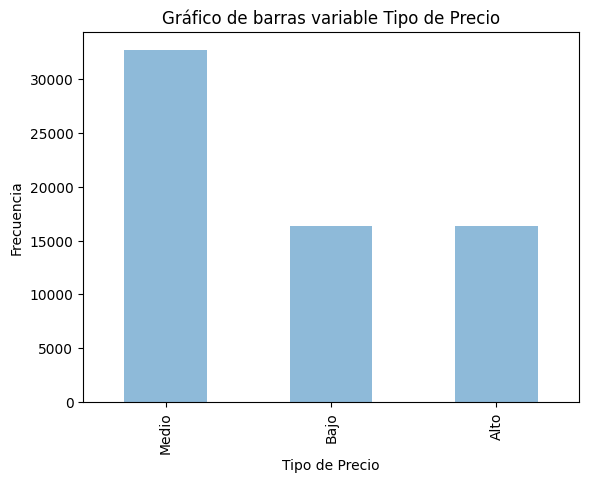

In [172]:
barras_pxm2_ascending_3=pxm2_ascending_3_con_tipo_precio['tipo_precio'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Tipo de Precio",
                                                      xlabel="Tipo de Precio" ,
                                                      ylabel="Frecuencia")

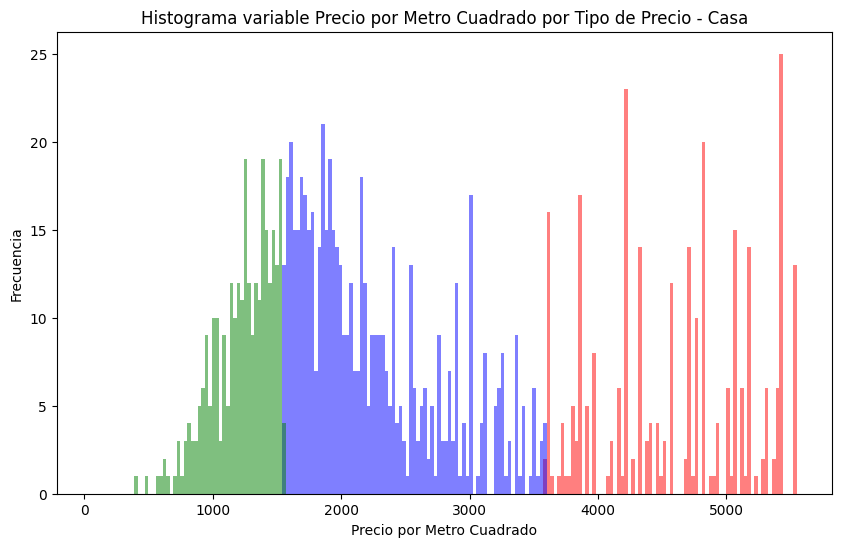

In [173]:
bin_edges = np.linspace(pxm2_ascending['price_per_square_meter'].min(), pxm2_ascending['price_per_square_meter'].max(), 201)
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending_3_con_tipo_precio[(pxm2_ascending_3_con_tipo_precio['tipo_precio'] == tipo_precio) & (pxm2_ascending_3_con_tipo_precio['property_type'] == 'Casa')]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=bin_edges, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio - Casa")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

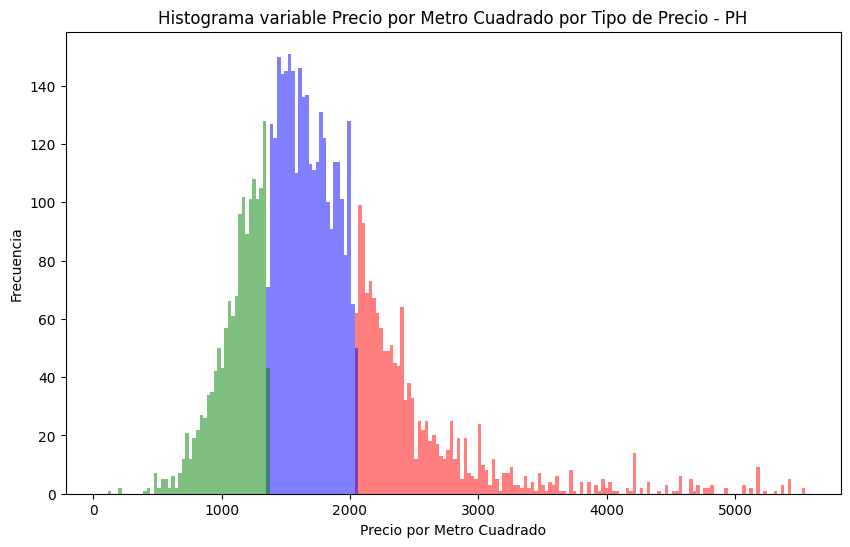

In [174]:
bin_edges = np.linspace(pxm2_ascending['price_per_square_meter'].min(), pxm2_ascending['price_per_square_meter'].max(), 201)
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending_3_con_tipo_precio[(pxm2_ascending_3_con_tipo_precio['tipo_precio'] == tipo_precio) & (pxm2_ascending_3_con_tipo_precio['property_type'] == 'PH')]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=bin_edges, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio - PH")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

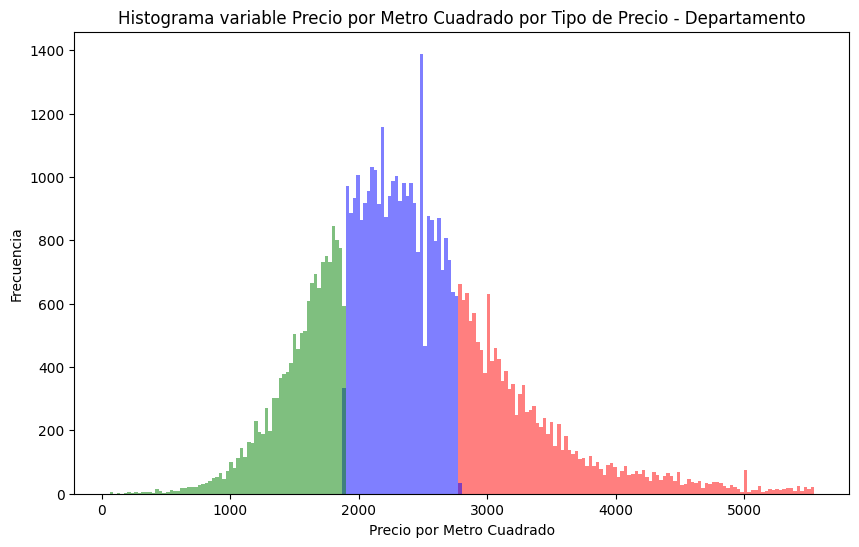

In [175]:
bin_edges = np.linspace(pxm2_ascending['price_per_square_meter'].min(), pxm2_ascending['price_per_square_meter'].max(), 201)
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending_3_con_tipo_precio[(pxm2_ascending_3_con_tipo_precio['tipo_precio'] == tipo_precio) & (pxm2_ascending_3_con_tipo_precio['property_type'] == 'Departamento')]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=bin_edges, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio - Departamento")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

## b. Entrenamiento y Prediccion

### Transformacion del dataset de entrenamiento

In [176]:
pxm2_ascending_3_con_tipo_precio.head()

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter,tipo_precio
0,-34.574142,-58.408867,Palermo,Casa,2.0,3.0,72.0,230.0,90000.0,391.304348,Bajo
1,-34.608300,-58.371200,Monserrat,Casa,2.0,3.0,67.0,83.0,40000.0,481.927711,Bajo
2,-34.657288,-58.411771,Nueva Pompeya,Casa,2.0,3.0,80.0,132.0,74000.0,560.606061,Bajo
3,-34.646343,-58.363495,Boca,Casa,2.0,3.0,117.0,146.0,85000.0,582.191781,Bajo
4,-34.653845,-58.464647,Parque Avellaneda,Casa,2.0,3.0,91.0,91.0,56800.0,624.175824,Bajo


Se pide predecir el atributo tipo_precio excluyendo del entrenamiento la variable price, pxm2 y cualquier otra que pueda tener el precio de la venta.

In [177]:
df_por_tipo_de_propiedad = pxm2_ascending_3_con_tipo_precio.copy()

In [178]:
#Eliminar las columnas pxm2 y precio de la propiedad
df_por_tipo_de_propiedad.drop(['price_per_square_meter','property_price'], axis="columns", inplace=True)


In [179]:
df_por_tipo_de_propiedad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65450 entries, 0 to 65449
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   65450 non-null  float64
 1   longitud                  65450 non-null  float64
 2   place_l3                  65445 non-null  object 
 3   property_type             65450 non-null  object 
 4   property_bedrooms         65450 non-null  float64
 5   property_rooms            65450 non-null  float64
 6   property_surface_covered  65450 non-null  float64
 7   property_surface_total    65450 non-null  float64
 8   tipo_precio               65450 non-null  object 
dtypes: float64(6), object(3)
memory usage: 4.5+ MB


vamos a utilizar oneHot para las columnas place_l3 y property_type

In [180]:
oneHot = OneHotEncoder()

In [181]:
df_dummies = pd.get_dummies(df_por_tipo_de_propiedad, columns=['property_type'], drop_first=False, dtype=int)

Para place_l3, vamos a calcular la cantidad de palabras y cuántas son en total, luego dropear el texto.

In [182]:
df_dummies['title_len'] = df_dummies['place_l3'].str.len()
df_dummies['title_words'] = df_dummies['place_l3'].str.split().str.len()
df_dummies.drop(['place_l3'], axis=1, inplace=True)
df_dummies

,latitud,longitud,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,tipo_precio,property_type_Casa,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.574142,-58.408867,2.0,3.0,72.0,230.0,Bajo,1,0,0,7.0,1.0
1,-34.608300,-58.371200,2.0,3.0,67.0,83.0,Bajo,1,0,0,9.0,1.0
2,-34.657288,-58.411771,2.0,3.0,80.0,132.0,Bajo,1,0,0,13.0,2.0
3,-34.646343,-58.363495,2.0,3.0,117.0,146.0,Bajo,1,0,0,4.0,1.0
4,-34.653845,-58.464647,2.0,3.0,91.0,91.0,Bajo,1,0,0,17.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
65445,-34.555664,-58.457325,1.0,2.0,48.0,56.0,Alto,0,1,0,8.0,1.0
65446,-34.555664,-58.457325,1.0,2.0,48.0,56.0,Alto,0,1,0,8.0,1.0
65447,-34.619000,-58.360553,1.0,2.0,60.0,65.0,Alto,0,1,0,13.0,2.0
65448,-34.597831,-58.388162,2.0,3.0,67.0,83.0,Alto,0,1,0,8.0,1.0


Escalo las variables numéricas.

In [183]:
columnas_num = [ 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered','title_len','title_words']

In [184]:
standard_scaler = StandardScaler()
df_dummies[columnas_num] = standard_scaler.fit_transform(df_dummies[columnas_num])

In [185]:
df_dummies.head(10)

,latitud,longitud,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,tipo_precio,property_type_Casa,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.574142,-58.408867,0.442879,0.495165,0.458707,4.684825,Bajo,1,0,0,-0.793343,-0.637623
1,-34.608300,-58.371200,0.442879,0.495165,0.277233,0.397241,Bajo,1,0,0,-0.143673,-0.637623
2,-34.657288,-58.411771,0.442879,0.495165,0.749065,1.826436,Bajo,1,0,0,1.155667,1.230711
3,-34.646343,-58.363495,0.442879,0.495165,2.091970,2.234777,Bajo,1,0,0,-1.767848,-0.637623
4,-34.653845,-58.464647,0.442879,0.495165,1.148307,0.630579,Bajo,1,0,0,2.455007,1.230711
5,-34.654748,-58.427318,0.442879,0.495165,0.821654,2.351446,Bajo,1,0,0,1.155667,1.230711
6,-34.657288,-58.411771,0.442879,0.495165,0.386117,1.359760,Bajo,1,0,0,1.155667,1.230711
7,-34.647901,-58.507039,0.442879,0.495165,0.749065,2.934791,Bajo,1,0,0,-0.793343,-0.637623
8,-34.593367,-58.376541,0.442879,0.495165,0.313528,-0.040268,Bajo,1,0,0,-1.118178,-0.637623
9,-34.648968,-58.461769,0.442879,0.495165,2.200854,2.351446,Bajo,1,0,0,-1.118178,-0.637623


### Modelo 1 : Árbol de decisión

#### Construccion del arbol

In [186]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

vamos a separar el dataset.

In [187]:
df_dummies.dropna(inplace=True)

In [188]:
x_train = df_dummies.drop(['tipo_precio'], axis='columns', inplace=False)
y_train = df_dummies['tipo_precio'].copy()

In [189]:
#combinaciones que voy a probar
n=10

#parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'], 'min_samples_leaf':list(range(1,10)), 'min_samples_split': list(range(3,20)),
               'ccp_alpha':np.linspace(0,0.05,n), 'max_depth':list(range(1,6))}

#splits para el Cross Validation
folds=15

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits= folds)

base_tree = DecisionTreeClassifier()

#Metrica optimiza F1 Score
scorer_fn =  make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree, param_distributions = params_grid, scoring=scorer_fn, cv=kfoldcv, error_score='raise', n_iter=n)

#hiperparametros que optimizan F1 Score
randomcv.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=15, random_state=None, shuffle=False),
                   error_score='raise', estimator=DecisionTreeClassifier(),
                   param_distributions={'ccp_alpha': array([0.        , 0.00555556, 0.01111111, 0.01666667, 0.02222222,
       0.02777778, 0.03333333, 0.03888889, 0.04444444, 0.05      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [3, 4, 5, 6, 7, 8,
                                                              9, 10, 11, 12, 13,
                                                              14, 15, 16, 17,
                                                              18, 19]},
                   scoring=make_scorer(f1_score, average=micro))

Para alcanzar su maximo valor en las metricas vamos a utilizar 15 folds.
 Elegimos F1 score por que es un balance entre las métricas de recall y presicion, preferimos no tener falsos negativos/positivos cuando predecimos el tipo de precio.

In [190]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)

#Mejor métrica
print(randomcv.best_score_)

{'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4, 'criterion': 'gini', 'ccp_alpha': 0.0}
0.544243257697303


Conseguimos los mejores parámetros y la mejor métrica de las 10 iteraciones realizadas.

In [191]:
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,x_train.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

property_type_PH: 0.0031862778877581764
property_surface_covered: 0.006283963793077786
property_surface_total: 0.030149685578185818
title_len: 0.044545901309100404
longitud: 0.24291041628594923
latitud: 0.6729237551459284


Podemos ver los atributos que el árbol considera importantes para la clasificación.

Creamos el árbol que tiene los mejores hiperparámetros

In [192]:
arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(x_train.columns))
print(reglas)

|--- latitud <= -34.60
|   |--- longitud <= -58.42
|   |   |--- latitud <= -34.63
|   |   |   |--- latitud <= -34.66
|   |   |   |   |--- class: Bajo
|   |   |   |--- latitud >  -34.66
|   |   |   |   |--- class: Bajo
|   |   |--- latitud >  -34.63
|   |   |   |--- property_surface_total <= 0.35
|   |   |   |   |--- class: Medio
|   |   |   |--- property_surface_total >  0.35
|   |   |   |   |--- class: Medio
|   |--- longitud >  -58.42
|   |   |--- longitud <= -58.37
|   |   |   |--- latitud <= -34.60
|   |   |   |   |--- class: Bajo
|   |   |   |--- latitud >  -34.60
|   |   |   |   |--- class: Medio
|   |   |--- longitud >  -58.37
|   |   |   |--- title_len <= -0.96
|   |   |   |   |--- class: Bajo
|   |   |   |--- title_len >  -0.96
|   |   |   |   |--- class: Alto
|--- latitud >  -34.60
|   |--- longitud <= -58.47
|   |   |--- property_surface_total <= -0.67
|   |   |   |--- property_type_PH <= 0.50
|   |   |   |   |--- class: Medio
|   |   |   |--- property_type_PH >  0.50
|   | 

In [193]:
feact = x_train.columns

In [126]:
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,filled=True, rounded=True,special_characters=True,
                feature_names=x_train.columns.to_list(),class_names=['Alto','Bajo','Medio'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

Podemos apreciar que clasifica un registro según los atributos que considera importantes expuestos anteriormente. Comienza considerando su latitud y, en el caso de la raíz, y según si cumple o no la condición se mueve hacia la derecha o izquierda.
El procedimiento sigue igual hasta llegar a la hoja en donde termina por clasificar el registro.

#### Conjunto de prueba

Vamos a evaluar con conjunto de prueba


In [194]:
df_dummies.head()

,latitud,longitud,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,tipo_precio,property_type_Casa,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.574142,-58.408867,0.442879,0.495165,0.458707,4.684825,Bajo,1,0,0,-0.793343,-0.637623
1,-34.608300,-58.371200,0.442879,0.495165,0.277233,0.397241,Bajo,1,0,0,-0.143673,-0.637623
2,-34.657288,-58.411771,0.442879,0.495165,0.749065,1.826436,Bajo,1,0,0,1.155667,1.230711
3,-34.646343,-58.363495,0.442879,0.495165,2.091970,2.234777,Bajo,1,0,0,-1.767848,-0.637623
4,-34.653845,-58.464647,0.442879,0.495165,1.148307,0.630579,Bajo,1,0,0,2.455007,1.230711


In [195]:
conjunto_prueba = pd.read_csv("Datasets/conjunto_prueba.csv")
df_prueba = conjunto_prueba.copy()
df_prueba.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,dSC4wqerxQ5zoezS10hyig==,2021-08-24,2021-08-27,2021-08-24,-34.594832,-58.419821,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,26.0,26.0,64765.0,USD,MONOAMBIENTE EMPRENDIMIENTO PALERMO SOHO
1,bObxHjQo1w/XUoA1CjdLtg==,2021-08-24,2021-08-24,2021-08-24,-34.585604,-58.423957,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,NaN,32.0,30.0,110000.0,USD,Venta departamento en palermo monoambiente
2,xIjDPpdsenrj6u6ErpdNhg==,2021-08-24,2021-08-27,2021-08-24,-34.582800,-58.442800,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,36.0,32.0,93621.0,USD,VENTA 1 AMBIENTE de 32 a 66 m² -VIVIENDA/ ESTU...
3,8b+kN4SeOF7UBH5dpfvg0Q==,2021-08-24,2021-10-18,2021-08-24,-34.577400,-58.433300,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,42.0,38.0,79900.0,USD,VENTA DEPARTAMENTO 2 AMBIENTES EN PALERMO
4,O1XW6eVlW04mfAkXRKePkQ==,2021-08-24,2022-03-21,2021-08-24,-34.575328,-58.420624,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,47.0,41.0,155000.0,USD,DEPARTAMENTO DUPLEX 2 AMBIENTES CON 2 BALCONES...


Vamos a preparar el dataset para poder utulizarlo

In [196]:
df_prueba.drop(['id', 'start_date', 'end_date', 'created_on', 'place_l5', 'place_l6', 'operation', 'place_l2', 'property_currency'], axis=1, inplace=True)
df_prueba.rename(columns={"place_l3":"zone"}, inplace=True)
df_prueba['zone'] = df_prueba.apply(lambda x: x['zone'] if str(x['place_l4']) == 'nan' else x['place_l4'], axis=1)
df_prueba.drop(['place_l4'], axis=1, inplace=True)

Se calcula las medias de latitud y longitud por zona y luego reemplaza los valores faltantes en el DataFrame original con esas medias

In [197]:
zones = df_prueba["zone"].unique()
media_zones = {}

for zone in zones:
      zone_act = df_prueba[df_prueba["zone"]==zone]
      lat_med = zone_act["latitud"].mean()
      lon_med = zone_act["longitud"].mean()
      media_zones[zone] = (lat_med,lon_med)
      zone_act = zone_act.fillna({"latitud":lat_med,"longitud":lon_med})
      df_prueba[df_prueba["zone"]==zone]=zone_act

In [198]:
import math

i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["latitud"]
  if math.isnan(lat):
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1

df_prueba.reset_index(drop=True, inplace=True)
df_prueba["latitud"].isna().value_counts()

latitud
False    18818
Name: count, dtype: int64

In [199]:
for i in range(0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  bool = pd.isna(zona)
  
  if bool:
    lat=fila["latitud"]
    lon=fila["longitud"]
    dist_menor = abs( abs(media_zones["Palermo"][0]) - abs(lat) ) + abs( abs( abs(media_zones["Palermo"][1] ) - abs(lon) ))
    barrio = "Palermo"

    for a in media_zones:
        tupla_dist = media_zones.get(a)
        nueva_dist = abs( abs(tupla_dist[0]) - abs(lat) ) + abs( abs( abs(tupla_dist[1] ) - abs(lon) ))
        es_menor = nueva_dist<dist_menor

        if es_menor:
          dist_menor=nueva_dist
          barrio = a
    df_prueba.loc[i, "zone"] = barrio

In [200]:
i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["zone"]
  if pd.isna(str(lat)):
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1

df_prueba.reset_index(drop=True, inplace=True)
df_prueba["zone"].isna().value_counts()

zone
False    18818
Name: count, dtype: int64

In [201]:
prec_m2 = {}
for zona in zones:
  zona_act = df_prueba[df_prueba["zone"]==zona].reset_index(drop=True)
  prec_tot = 0
  sup_tot = 0

  for i in range(0,zona_act.shape[0]):
    fila = zona_act.iloc[i]
    prec = fila["property_price"]
    sup = fila["property_surface_total"]

    if not pd.isna(sup):
      prec_tot+=prec
      sup_tot+=sup

  if sup_tot!=0:
    prec_prom = prec_tot/sup_tot

    prec_m2[zona]= prec_prom

for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  sup = fila["property_surface_total"]
  if pd.isna(sup):
      prec = fila["property_price"]
      sup_calc = prec/prec_m2.get(zona)
      df_prueba.loc[i, "property_surface_total"] = sup_calc

In [202]:
i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["property_surface_total"]
  if pd.isna(lat):
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1

df_prueba.reset_index(drop=True, inplace=True)
df_prueba["property_surface_total"].isna().value_counts()

property_surface_total
False    18818
Name: count, dtype: int64

In [203]:
porc_sup_cub = {}

for zona in zones:
  zona_act = df_prueba[df_prueba["zone"]==zona].reset_index(drop=True)
  sup_tot = 0
  sup_cub = 0

  for i in range(0,zona_act.shape[0]):
    fila = zona_act.iloc[i]
    s_tot = fila["property_surface_total"]
    s_cub = fila["property_surface_covered"]

    #si la columna property_surface_covered no es NaN
    if not pd.isna(sup_cub):
      sup_tot+=s_tot
      sup_cub+=s_cub

  if sup_tot!=0:
    porc_cub = (sup_cub * 100)/sup_tot
    porc_sup_cub[zona]= porc_cub

In [204]:
for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  sup_cub = fila["property_surface_covered"]
  if pd.isna(sup_cub):
      sup_tot = fila["property_surface_total"]
      nueva_sup_cub = sup_tot * porc_sup_cub.get(zona)
      df_prueba.loc[i, "property_surface_covered"] = nueva_sup_cub

In [205]:
i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["property_surface_covered"]
  if pd.isna(lat):
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1

df_prueba.reset_index(drop=True, inplace=True)
df_prueba["property_surface_covered"].isna().value_counts()

property_surface_covered
False    18343
Name: count, dtype: int64

In [206]:
met_por_hab = {}

for zona in zones:
  zona_act = df_prueba[df_prueba["zone"]==zona]
  r_mediana = zona_act["property_rooms"].median()
  s_mediana = zona_act["property_surface_total"].median()
  met_por_hab[zona]=s_mediana/r_mediana

In [207]:
for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  rooms = fila["property_rooms"]
  if pd.isna(rooms):
      sup_cub = fila["property_surface_covered"]
      nuevo_rooms = sup_cub / met_por_hab.get(zona)
      df_prueba.loc[i, "property_rooms"] = round(nuevo_rooms)

In [208]:
i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["property_rooms"]
  if pd.isna(lat):
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1
df_prueba.reset_index(drop=True, inplace=True)
df_prueba["property_rooms"].isna().value_counts()

property_rooms
False    18343
Name: count, dtype: int64

In [209]:
por_bedrooms = {}

rooms=df_prueba["property_rooms"].median()
bedrooms=df_prueba["property_bedrooms"].median()
porcentaje_mediana_gral = (bedrooms*100)/rooms

for zona in zones:
  zona_act = df_prueba[df_prueba["zone"]==zona]
  r_mediana = zona_act["property_rooms"].median()
  b_mediana = zona_act["property_bedrooms"].median()
  porcentaje = (b_mediana * 100)/r_mediana
  if porcentaje==100.0:
    porcentaje=porcentaje_mediana_gral
  por_bedrooms[zona] = porcentaje

In [210]:
for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  bedrooms = fila["property_bedrooms"]
  if pd.isna(bedrooms):
      rooms = fila["property_rooms"]
      calc_bedrooms = (rooms*por_bedrooms.get(zona)/100)
      df_prueba.loc[i, "property_bedrooms"] = round(calc_bedrooms)

In [211]:
i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["property_bedrooms"]
  if pd.isna(lat):
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1
df_prueba.reset_index(drop=True, inplace=True)
df_prueba["property_bedrooms"].isna().value_counts()

property_bedrooms
False    18343
Name: count, dtype: int64

In [212]:
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18343 entries, 0 to 18342
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   18343 non-null  float64
 1   longitud                  18343 non-null  float64
 2   zone                      18343 non-null  object 
 3   property_type             18343 non-null  object 
 4   property_rooms            18343 non-null  float64
 5   property_bedrooms         18343 non-null  float64
 6   property_surface_total    18343 non-null  float64
 7   property_surface_covered  18343 non-null  float64
 8   property_price            18343 non-null  float64
 9   property_title            18343 non-null  object 
dtypes: float64(7), object(3)
memory usage: 1.4+ MB


Terminamos dropeando todas las filas que tienen datos nulos al finalizar

In [213]:
df_prueba.to_csv("Datasets/conjunto_prueba_reducido.csv")

#### Preparar target

In [214]:
df_prueba['price_per_square_meter'] = df_prueba['property_price'] / df_prueba['property_surface_total']

df_prueba_casa = df_prueba[df_prueba['property_type'] == "Casa"].reset_index(drop=True)
df_prueba_casa = assign_tipo_precio(df_prueba_casa)
df_prueba_ph = df_prueba[df_prueba['property_type'] == "PH"].reset_index(drop=True)
df_prueba_ph = assign_tipo_precio(df_prueba_ph)
df_prueba_dpt = df_prueba[df_prueba['property_type'] == "Departamento"].reset_index(drop=True)
df_prueba_dpt = assign_tipo_precio(df_prueba_dpt)
df_prueba_con_tipo_precio = pd.concat([df_prueba_casa, df_prueba_ph, df_prueba_dpt]).reset_index(drop=True)
df_prueba_con_tipo_precio

,latitud,longitud,zone,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,price_per_square_meter,tipo_precio
0,-34.543571,-58.465663,Nuñez,Casa,6.0,5.0,339.0,280.0,498000.0,"Venta de Casa 6 AMBIENTES, triplex, ambientes ...",1469.026549,Bajo
1,-34.624894,-58.517233,Floresta,Casa,3.0,2.0,80.0,66.0,115000.0,Casa en 2 Plantas 3 Amb y Terraza Propia / Ver...,1437.500000,Bajo
2,-34.616682,-58.370235,San Telmo,Casa,1.0,1.0,309.0,280.0,420000.0,Casa - San Telmo,1359.223301,Bajo
3,-34.624894,-58.517233,Versalles,Casa,3.0,2.0,80.0,66.0,115000.0,Casa en 2 Plantas 3 Amb y Terraza Propia / Ver...,1437.500000,Bajo
4,-34.635058,-58.437412,Parque Chacabuco,Casa,7.0,6.0,257.0,226.0,150000.0,Casa - Flores Sur,583.657588,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...
18338,-34.603245,-58.489810,Villa del Parque,Departamento,4.0,3.0,130.0,100.0,220000.0,Espectacular 4 amb130m2 con Balcon Terraza!!!,1692.307692,Alto
18339,-34.614063,-58.482814,Villa del Parque,Departamento,3.0,2.0,68.0,60.0,161000.0,3 ambientes con cochera listo para habitar!,2367.647059,Alto
18340,-34.614175,-58.479062,Villa del Parque,Departamento,1.0,1.0,51.0,30.0,75500.0,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,1480.392157,Alto
18341,-34.614175,-58.479062,Villa del Parque,Departamento,1.0,1.0,37.0,31.0,74500.0,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,2013.513514,Alto


In [215]:
df_prueba_con_tipo_precio.dropna(inplace=True)

In [216]:
df_prueba_con_tipo_precio.drop(['price_per_square_meter', 'property_price'], axis=1, inplace=True)

In [217]:
df_prueba_con_tipo_precio.shape

(18343, 10)

#### Ingeniería de características

In [218]:
df_prueba_dummies = pd.get_dummies(df_prueba_con_tipo_precio, columns=['property_type'],drop_first=False, dtype=int)
df_prueba_dummies['title_len'] = df_prueba_dummies['zone'].str.len()
df_prueba_dummies['title_words'] = df_prueba_dummies['zone'].str.split().str.len()
df_prueba_dummies.drop(['zone'], axis=1, inplace=True)

In [219]:
standard_scaler = StandardScaler()
df_prueba_dummies[columnas_num] = standard_scaler.fit_transform(df_prueba_dummies[columnas_num])

In [220]:
df_prueba_dummies

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_title,tipo_precio,property_type_Casa,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.543571,-58.465663,1.973661,2.746470,0.193597,0.160044,"Venta de Casa 6 AMBIENTES, triplex, ambientes ...",Bajo,1,0,0,-1.438120,-0.673381
1,-34.624894,-58.517233,0.107374,0.098686,-0.023944,-0.021574,Casa en 2 Plantas 3 Amb y Terraza Propia / Ver...,Bajo,1,0,0,-0.483404,-0.673381
2,-34.616682,-58.370235,-1.136818,-0.783908,0.168400,0.160044,Casa - San Telmo,Bajo,1,0,0,-0.165166,1.140398
3,-34.624894,-58.517233,0.107374,0.098686,-0.023944,-0.021574,Casa en 2 Plantas 3 Amb y Terraza Propia / Ver...,Bajo,1,0,0,-0.165166,-0.673381
4,-34.635058,-58.437412,2.595757,3.629064,0.124723,0.114215,Casa - Flores Sur,Bajo,1,0,0,2.062505,1.140398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18338,-34.603245,-58.489810,0.729469,0.981281,0.018052,0.007281,Espectacular 4 amb130m2 con Balcon Terraza!!!,Alto,0,1,0,2.062505,2.954177
18339,-34.614063,-58.482814,0.107374,0.098686,-0.034023,-0.026666,3 ambientes con cochera listo para habitar!,Alto,0,1,0,2.062505,2.954177
18340,-34.614175,-58.479062,-1.136818,-0.783908,-0.048302,-0.052126,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,Alto,0,1,0,2.062505,2.954177
18341,-34.614175,-58.479062,-1.136818,-0.783908,-0.060061,-0.051277,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,Alto,0,1,0,2.062505,2.954177


Reorganizo las columnas para que me queden en el mismo orden, las de prueba y las de entrenamiento

In [221]:
column_order = df_dummies.columns
df_prueba_dummies = df_prueba_dummies[column_order]

In [222]:
df_dummies.head(1)

,latitud,longitud,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,tipo_precio,property_type_Casa,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.574142,-58.408867,0.442879,0.495165,0.458707,4.684825,Bajo,1,0,0,-0.793343,-0.637623


In [223]:
df_prueba_dummies.head(1)

,latitud,longitud,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,tipo_precio,property_type_Casa,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.543571,-58.465663,2.74647,1.973661,0.160044,0.193597,Bajo,1,0,0,-1.43812,-0.673381


#### Realizamos la Predicción

In [224]:
x_prueba = df_prueba_dummies.drop(['tipo_precio'], axis='columns', inplace=False)
y_prueba = df_prueba_dummies['tipo_precio'].copy()

F1-Score: 0.40151556452052556


Text(50.722222222222214, 0.5, 'True')

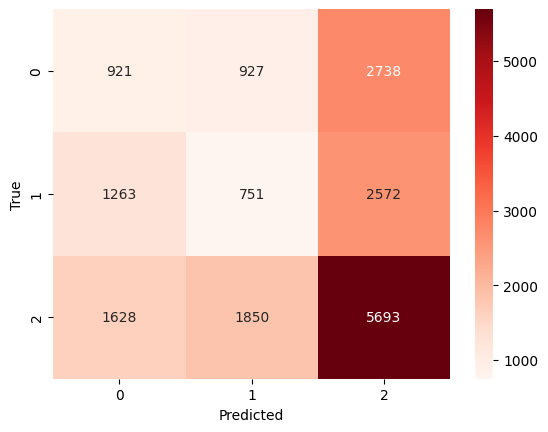

In [228]:
#predicción sobre el set de evaluacion
y_pred = arbol.predict(x_prueba)

#Arbol Reporte
#Matriz de Confusion
print('F1-Score: {}'.format(f1_score(y_prueba, y_pred, average='micro')))

cm = confusion_matrix(y_prueba,y_pred)
sns.heatmap(cm, cmap='Reds',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')


In [229]:
print(classification_report(y_prueba, y_pred))

              precision    recall  f1-score   support

        Alto       0.24      0.20      0.22      4586
        Bajo       0.21      0.16      0.19      4586
       Medio       0.52      0.62      0.56      9171

    accuracy                           0.40     18343
   macro avg       0.32      0.33      0.32     18343
weighted avg       0.37      0.40      0.38     18343



Observamos que la métrica de precisión resulta de 0,5 para las tres clases, indica la cantidad de casos verdaderos sobre la cantidad de casos que predecimos como verdaderos.

La métrica recall indica la cantidad de casos clasificados como positivos sobre lo que realmente es positivo.Nos dio un valor bajo para el caso de propiedades bajas y altas.

### Modelo 2: Random Forest

#### Construccion del modelo

In [231]:
#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.05,n),
               'max_depth':list(range(1,6))}

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
k_fold_cv_random_forest = StratifiedKFold(n_splits=folds)

#Clasificador
base_random_forest = RandomForestClassifier(
    max_features=0.5,
    oob_score=True,
    random_state=1,
    n_jobs=-1
)

#Metrica que quiero optimizar F1 Score
scorer_fn_random_forest_version = make_scorer(f1_score)

#Random Search Cross Validation
random_cv_random_forest_version = RandomizedSearchCV(
                              estimator=base_random_forest,
                              param_distributions = params_grid,
                              scoring=scorer_fn_random_forest_version,
                              cv=k_fold_cv_random_forest,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
random_cv_random_forest_version.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(max_features=0.5, n_jobs=-1,
                                                    oob_score=True,
                                                    random_state=1),
                   param_distributions={'ccp_alpha': array([0.        , 0.00555556, 0.01111111, 0.01666667, 0.02222222,
       0.02777778, 0.03333333, 0.03888889, 0.04444444, 0.05      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19]},
                   scoring=make_scorer(f1_score))

#### Mejores hiperparametros del arbol

In [232]:
random_cv_random_forest_version.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 4,
 'criterion': 'entropy',
 'ccp_alpha': 0.011111111111111112}

#### Analisis de la importancia de los atributos

In [233]:
best_rf = random_cv_random_forest_version.best_estimator_
feat_imps = best_rf.feature_importances_
print(feat_imps)

for feat_imp,feat in sorted(zip(feat_imps,df_dummies.columns)):
  if feat_imp > 0:
    print('{}: {}'.format(feat,feat_imp))

[7.45146555e-01 1.54991858e-01 0.00000000e+00 4.91769952e-05
 5.83015458e-03 3.54514001e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.64035038e-02 4.03361149e-03]
property_rooms: 4.917699517583322e-05
property_surface_total: 0.0035451400078844856
title_len: 0.00403361149333882
property_surface_covered: 0.005830154583524385
property_type_PH: 0.08640350384911005
longitud: 0.15499185800136422
latitud: 0.7451465550696021


Observamos los atributos que mas peso tienen para determinar si es de costo Alto, Medio o Bajo.
- Latitud y el tipo de propiedad son los mas considerados.

#### Conformación final de uno de los árboles generados

 Entranamos el modelo con los hiperparametros optimizados

In [234]:
params = random_cv_random_forest_version.best_params_
rfc_optimizado = RandomForestClassifier().set_params(**params)
#Aca entrenamos el modelo
model_rf = rfc_optimizado.fit(X = x_train, y = y_train)

In [235]:
model_rf.estimators_[48]

DecisionTreeClassifier(ccp_alpha=0.011111111111111112, criterion='entropy',
                       max_depth=4, max_features='sqrt', min_samples_leaf=3,
                       random_state=1233266418)

In [237]:
plt.figure(figsize=(100,100))

tree_plot_completo = plot_tree(model_rf.estimators_[48],
                                 feature_names=x_train.columns.to_list(),
                                 filled=True,
                                 rounded=True,
                                 class_names=['Bajo','Medio','Alto'])
plt.show(tree_plot_completo)

#### Evaluacion de la performance del modelo

Text(50.722222222222214, 0.5, 'True')

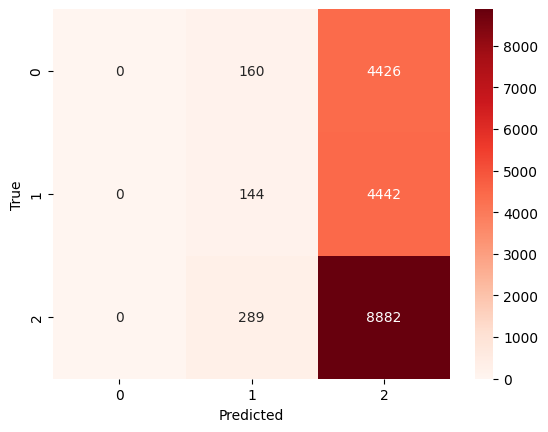

In [238]:
y_pred_model_rfc_multimetrica = model_rf.predict(x_prueba)
#Matriz de Confusión
cm = confusion_matrix(y_prueba,y_pred_model_rfc_multimetrica)
sns.heatmap(cm, cmap='Reds',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [239]:
print(classification_report(y_prueba,y_pred_model_rfc_multimetrica))

              precision    recall  f1-score   support

        Alto       0.00      0.00      0.00      4586
        Bajo       0.24      0.03      0.06      4586
       Medio       0.50      0.97      0.66      9171

    accuracy                           0.49     18343
   macro avg       0.25      0.33      0.24     18343
weighted avg       0.31      0.49      0.34     18343




*   Predice con una precisión del 95% costo Alto
*   Predice con una precisión del 53% costo Bajo
*   Predice con una precisión del 52% costo Medio


### Modelo 3: Regresion logistica

In [242]:
scorer_fn = make_scorer(f1_score, average='micro')
lr = LogisticRegressionCV(max_iter=10000,
                          tol=0.00001,
                          cv=10,
                          random_state=1,
                          n_jobs=-1,
                          scoring=scorer_fn)
lr.fit(x_train,y_train)
y_pred=lr.predict(x_prueba)

In [244]:
accuracy=accuracy_score(y_prueba,y_pred)
print("Accuracy: "+str(accuracy))
recall=recall_score(y_prueba,y_pred,average='weighted')
f1=f1_score(y_prueba,y_pred, average='weighted')
precision=precision_score(y_prueba,y_pred,average='weighted')

print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.4629013792727471
Recall: 0.4629013792727471
Precision: 0.32598172635696154
f1 score: 0.34897124691480763


Text(50.722222222222214, 0.5, 'True')

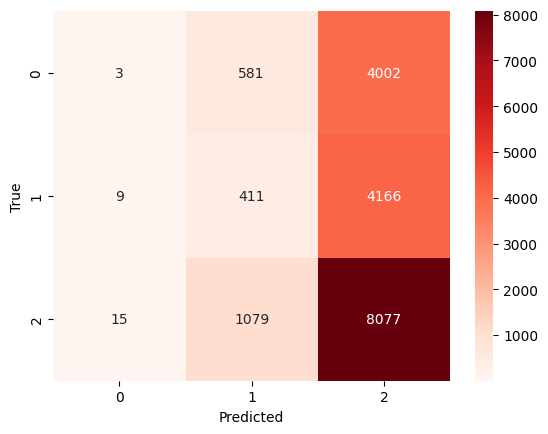

In [245]:
cm = confusion_matrix(y_prueba,y_pred)
sns.heatmap(cm, cmap='Reds',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# ¿Qué modelo elegirían para clasificar el tipo de precio de las propiedades?
Para clasificar nosotros nos parece mejor el  Modelo Random Forest.